## Binary Text Classification - SpamFilter - Large File

-This is the Feature Extraction Model that accompanies the (Fine-Tuned) Spam Filter that is listed as 'distilbert-base-uncased-SpamFilter-LG' on my HuggingFace profile

-Source for the Dataset: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

@article{Sanh2019DistilBERTAD,
  title={DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter},
  author={Victor Sanh and Lysandre Debut and Julien Chaumond and Thomas Wolf},
  journal={ArXiv},
  year={2019},
  volume={abs/1910.01108}
}

### Exploratory Data Analysis

#### Importing the Necessary Libraries for this Project

In [1]:
import os
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import numpy as np

import torch
from torch.nn.functional import cross_entropy

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, AdamW, get_scheduler, set_seed

from datasets import Dataset, DatasetDict

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier


import matplotlib.pyplot as plt

NOTE: Redirects are currently not supported in Windows or MacOs.


#### Versions of Many Libraries Used

In [2]:
print("Pandas:".ljust(18), pd.__version__)
print("NumPy:".ljust(18), np.__version__)
print("Torch:".ljust(18), torch.__version__)

Pandas:            1.4.3
NumPy:             1.22.4
Torch:             1.12.1


#### Basic Constants and Values Used

In [3]:
model_ckpt = "distilbert-base-uncased"
device = "cpu"
max_input_len = 50

learning_rate=2e-5
batch_size = 64

num_of_epochs = 2
model_name = f"{model_ckpt}-OnionOrNot"
set_seed(42)

#### Reading in the DataFrame to Pandas

In [4]:
data = pd.read_csv(r'/Users/briandunn/Documents/nlpnn/Datasets/SpamFilter (larger File)/spam.csv', engine='c')

data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)
data.rename(columns={'v2' : 'text', 'v1' : 'label'}, inplace=True)
data.drop_duplicates(inplace=True)
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Visualization of the Title Length

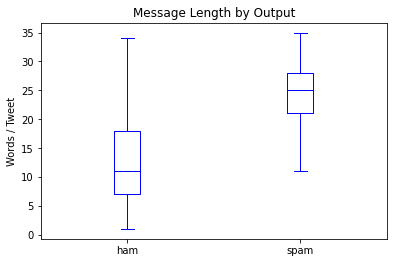

In [5]:
data['message_len'] = data['text'].str.split().apply(len)
data.boxplot("message_len", by="label", grid=False, showfliers=False, color="Blue")

plt.suptitle('')
plt.title('Message Length by Output')
plt.xlabel('')
plt.ylabel('Words / Tweet')
plt.show()

data = data.drop(columns=['message_len'])

#### Replace Label String Values with Integer Values

In [6]:
data['label'].replace({'ham' : 0, 'spam' : 1}, inplace=True)

### The Actual Project

#### Converting Pandas DataFrame to Dataset & Split into Train/Test/Valid Datasets

In [7]:
# Converts the pandas DataFrame to a Dataset
dataset = Dataset.from_pandas(data)
dataset.shuffle(seed=42)

# Splitting the Dataset into the train, test, and valid datasets and then packing all of them into a Dataset Dictionary
train_testvalid = dataset.train_test_split(test_size=0.20)

test_valid = train_testvalid['test'].train_test_split(test_size=0.5)

dataset = DatasetDict({
    'train': train_testvalid['train'], 
    'test': test_valid['test'], 
    'valid': test_valid['train']})

print('Training data shape:', dataset['train'].shape)
print('Testing data shape:', dataset['test'].shape)
print('Validation data shape:', dataset['valid'].shape)

Training data shape: (4126, 3)
Testing data shape: (516, 3)
Validation data shape: (516, 3)


#### Create Compute Metrics Function

In [8]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### Tokenize Dataset

In [9]:
num_labels=2
labels = ['Ham', 'Spam']
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding=True, max_length=max_input_len, return_tensors="np")

encoded_data = dataset.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Instantiate the Model

In [10]:
model = (AutoModel.from_pretrained(model_ckpt, num_labels=num_labels, output_hidden_states=True).to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Assess Results

#### Extract Last Hidden States

In [11]:
def extract_hidden_states(batch=True):
    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs)[0]
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

encoded_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

hidden_data = encoded_data.map(extract_hidden_states, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

#### Create Feature Matrix

In [12]:
X_train = np.array(hidden_data["train"]["hidden_state"])
X_valid = np.array(hidden_data["valid"]["hidden_state"])
y_train = np.array(hidden_data["train"]["label"])
y_valid = np.array(hidden_data["valid"]["label"])
X_train.shape, X_valid.shape

((4126, 768), (516, 768))

#### Create Function to Calculate & Display Confusion Matrix

In [13]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax)
    plt.title('Normalized Confusion Matrix')
    plt.show()

#### Logistic Regression for Comparison

In [14]:
log_reg_clf = LogisticRegression(max_iter=3000)
log_reg_clf.fit(X_train, y_train)
log_reg_clf.score(X_valid, y_valid)

0.9825581395348837

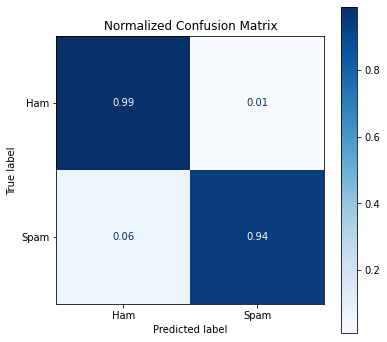

In [15]:
lr_y_preds = log_reg_clf.predict(X_valid)
plot_confusion_matrix(lr_y_preds, y_valid, labels)

#### Dummy Classifier for Comparison

In [16]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy.score(X_valid, y_valid)

0.8701550387596899

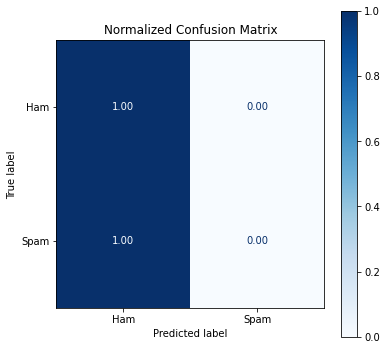

In [17]:
dc_y_preds = dummy.predict(X_valid)
plot_confusion_matrix(dc_y_preds, y_valid, labels)